Plot of q vs time


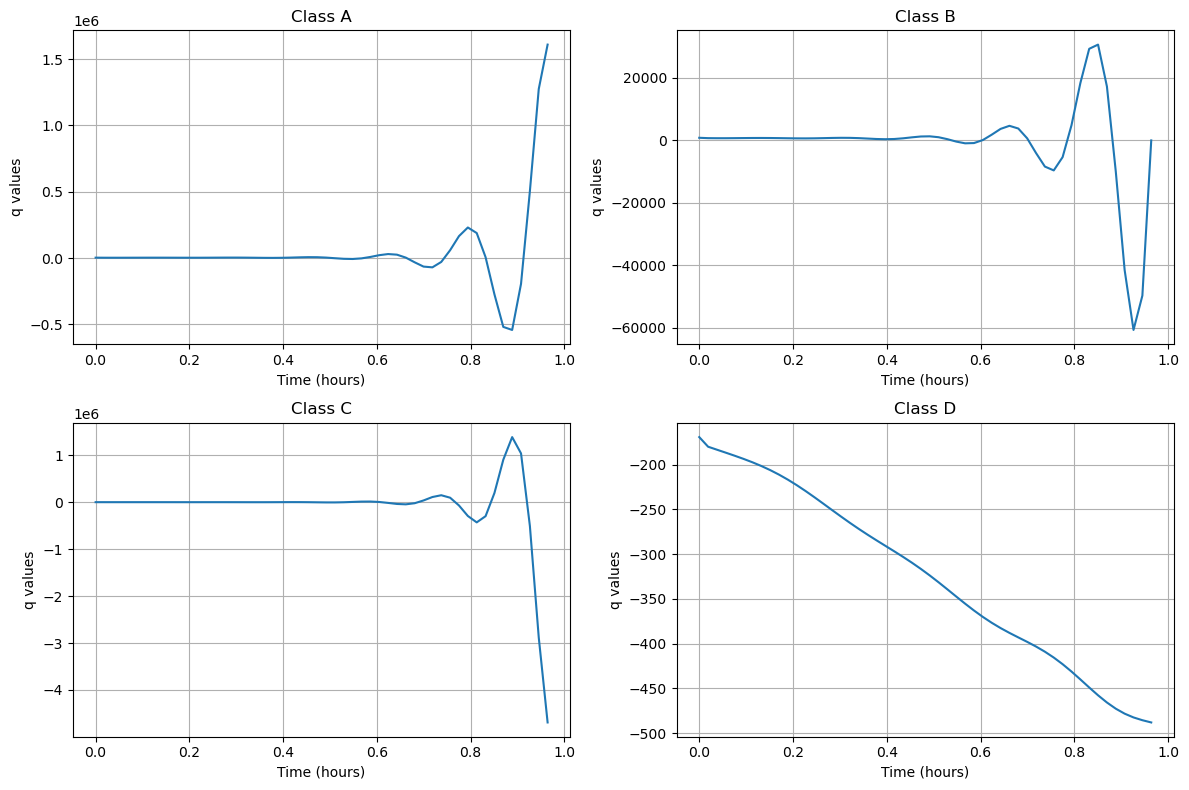

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define time parameters
T = 1.0  # total simulation time
dx = 1  # spatial step size in x direction
dy = 1  # spatial step size in y direction

# Define constants
W = 1  # Width of the road in km
r_i = {'A': 0.89, 'B': 0.78, 'C': 0.74, 'D': 0.50}
D_A, D_B, D_C, D_D = 0.00006, 0.00005, 0.00004, 0.00003  # Diffusion coefficients
AOmax_A, AOmax_B, AOmax_C, AOmax_D = 0.86, 0.78, 0.68, 0.50
a_A, a_B, a_C, a_D = 0.0018 * 0.0006, 0.0026 * 0.0014, 0.004 * 0.0016, 0.0065 * 0.0022

# Initialize densities
rho_A = np.zeros((50, 100))
rho_B = np.zeros((50, 100))
rho_C = np.zeros((50, 100))
rho_D = np.zeros((50, 100))

# Initialize AO matrix
AO = np.zeros((50, 100))

# Assign initial densities and AO based on the condition x < 25 or x >= 25
for x in range(50):
    if x < 25:
        rho_A[x, :] = 100
        rho_B[x, :] = 50
        rho_C[x, :] = 200
        rho_D[x, :] = 25
        AO[x, :] = 0.24
    else:
        rho_A[x, :] = 1200
        rho_B[x, :] = 400
        rho_C[x, :] = 500
        rho_D[x, :] = 100
        AO[x, :] = 0.82

# Initialize velocity fields
u_x_A = np.ones((50, 100)) * 45.0
u_y_A = np.ones((50, 100)) * 2.5
u_x_B = np.ones((50, 100)) * 42.1
u_y_B = np.ones((50, 100)) * 1.4
u_x_C = np.ones((50, 100)) * 52.9
u_y_C = np.ones((50, 100)) * 5.6
u_x_D = np.ones((50, 100)) * 47.2
u_y_D = np.ones((50, 100)) * 4.3

# Define inflow values
q_A_inflow = 500
q_B_inflow = 100
q_C_inflow = 50
q_D_inflow = 10

# Determine maximum velocities
u_x_max = max(np.max(u_x_A), np.max(u_x_B), np.max(u_x_C), np.max(u_x_D))
u_y_max = max(np.max(u_y_A), np.max(u_y_B), np.max(u_y_C), np.max(u_y_D))

# Determine maximum diffusion coefficient
D_max = max(D_A, D_B, D_C, D_D)

# Calculate the time step to satisfy CFL conditions
dt_advection_x = dx / u_x_max
dt_advection_y = dy / u_y_max
dt_diffusion_x = dx**2 / (2 * D_max)
dt_diffusion_y = dy**2 / (2 * D_max)

# Choose the smaller time step to ensure all conditions are satisfied
dt = min(dt_advection_x, dt_advection_y, dt_diffusion_x, dt_diffusion_y)

# Calculate number of time steps
time_steps = int(T / dt) + 1  # +1 ensures that final time is also included
time = np.arange(0, T, dt)  # array of times

# Define the finite difference gradient function
def finite_difference_gradient(f, dx, dy):
    grad_x = np.zeros(f.shape)
    grad_y = np.zeros(f.shape)
    grad_x[1:-1, 1:-1] = (f[2:, 1:-1] - f[:-2, 1:-1]) / (2 * dx)
    grad_y[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, :-2]) / (2 * dy)
    return grad_x, grad_y

# Define the finite difference second derivative function
def finite_difference_laplacian(f, dx, dy):
    laplacian_x = np.zeros(f.shape)
    laplacian_y = np.zeros(f.shape)
    laplacian_x[1:-1, 1:-1] = (f[2:, 1:-1] - 2 * f[1:-1, 1:-1] + f[:-2, 1:-1]) / dx**2
    laplacian_y[1:-1, 1:-1] = (f[1:-1, 2:] - 2 * f[1:-1, 1:-1] + f[1:-1, :-2]) / dy**2
    return laplacian_x, laplacian_y

# Function to update the density field
def update_density(rho, u_x, u_y, D, AO, AO_minus, dt, dx, dy, q_inflow, W, a):
    rho_new = np.copy(rho)

    AO_diff_x, AO_diff_y = finite_difference_gradient(AO - AO_minus, dx, dy)
    laplacian_x, laplacian_y = finite_difference_laplacian(AO - AO_minus, dx, dy)

    # Update densities excluding boundaries
    rho_new[1:-1, 1:-1] = (rho[1:-1, 1:-1]
                           - dt * (W / a) * ((u_x[1:-1, 1:-1] * AO_diff_x[1:-1, 1:-1])
                           + (u_y[1:-1, 1:-1] * AO_diff_y[1:-1, 1:-1]))
                           + dt * D * (W / a) * (laplacian_x[1:-1, 1:-1] + laplacian_y[1:-1, 1:-1]))

    # Apply inflow
    rho_new[:, 0] += q_inflow * dt

    return rho_new

# Function to calculate velocity
def calculate_ui(u_fi, r_i, AO_max_i, AO):
    return u_fi * (1 - np.exp(1 - np.exp(r_i * (AO_max_i / AO - 1))))

# Function to calculate q
def calculate_q(u_x, u_y, AO, AO_minus, D, W, a):
    AO_diff_x, AO_diff_y = finite_difference_gradient(AO - AO_minus, dx, dy)
    q = (W / a) * (u_x * (AO - AO_minus) - D * AO_diff_x + u_y * (AO - AO_minus) - D * AO_diff_y)
    return q

# Initialize lists to store q values over time
q_A_time = []
q_B_time = []
q_C_time = []
q_D_time = []

# Simulate densities and compute eigenvalues and velocities over time
for t in range(time_steps - 1):
    # Update densities
    AO_minus_A = AO - a_A * rho_A / W
    AO_minus_B = AO - a_B * rho_B / W
    AO_minus_C = AO - a_C * rho_C / W
    AO_minus_D = AO - a_D * rho_D / W

    rho_A = update_density(rho_A, u_x_A, u_y_A, D_A, AO, AO_minus_A, dt, dx, dy, q_A_inflow, W, a_A)
    rho_B = update_density(rho_B, u_x_B, u_y_B, D_B, AO, AO_minus_B, dt, dx, dy, q_B_inflow, W, a_B)
    rho_C = update_density(rho_C, u_x_C, u_y_C, D_C, AO, AO_minus_C, dt, dx, dy, q_C_inflow, W, a_C)
    rho_D = update_density(rho_D, u_x_D, u_y_D, D_D, AO, AO_minus_D, dt, dx, dy, q_D_inflow, W, a_D)

    # Calculate velocities
    u_x_A = calculate_ui(45.0, r_i['A'], AOmax_A, AO)
    u_y_A = calculate_ui(2.5, r_i['A'], AOmax_A, AO)
    u_x_B = calculate_ui(42.1, r_i['B'], AOmax_B, AO)
    u_y_B = calculate_ui(1.4, r_i['B'], AOmax_B, AO)
    u_x_C = calculate_ui(52.9, r_i['C'], AOmax_C, AO)
    u_y_C = calculate_ui(5.6, r_i['C'], AOmax_C, AO)
    u_x_D = calculate_ui(47.2, r_i['D'], AOmax_D, AO)
    u_y_D = calculate_ui(4.3, r_i['D'], AOmax_D, AO)

    # Calculate q values
    q_A = calculate_q(u_x_A, u_y_A, AO, AO_minus_A, D_A, W, a_A)
    q_B = calculate_q(u_x_B, u_y_B, AO, AO_minus_B, D_B, W, a_B)
    q_C = calculate_q(u_x_C, u_y_C, AO, AO_minus_C, D_C, W, a_C)
    q_D = calculate_q(u_x_D, u_y_D, AO, AO_minus_D, D_D, W, a_D)

    # Store the average q values over the domain
    q_A_time.append(np.mean(q_A))
    q_B_time.append(np.mean(q_B))
    q_C_time.append(np.mean(q_C))
    q_D_time.append(np.mean(q_D))

# Adjust time array to match the length of q lists
time = time[:-1]  # Remove the last element of time

# Plot the q values over time
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time, q_A_time, label='Class A')
plt.xlabel('Time (hours)')
plt.ylabel('q values')
plt.title('Class A')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(time, q_B_time, label='Class B')
plt.xlabel('Time (hours)')
plt.ylabel('q values')
plt.title('Class B')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(time, q_C_time, label='Class C')
plt.xlabel('Time (hours)')
plt.ylabel('q values')
plt.title('Class C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(time, q_D_time, label='Class D')
plt.xlabel('Time (hours)')
plt.ylabel('q values')
plt.title('Class D')
plt.grid(True)

plt.tight_layout()
plt.show()


Flow curves for vehicle classes

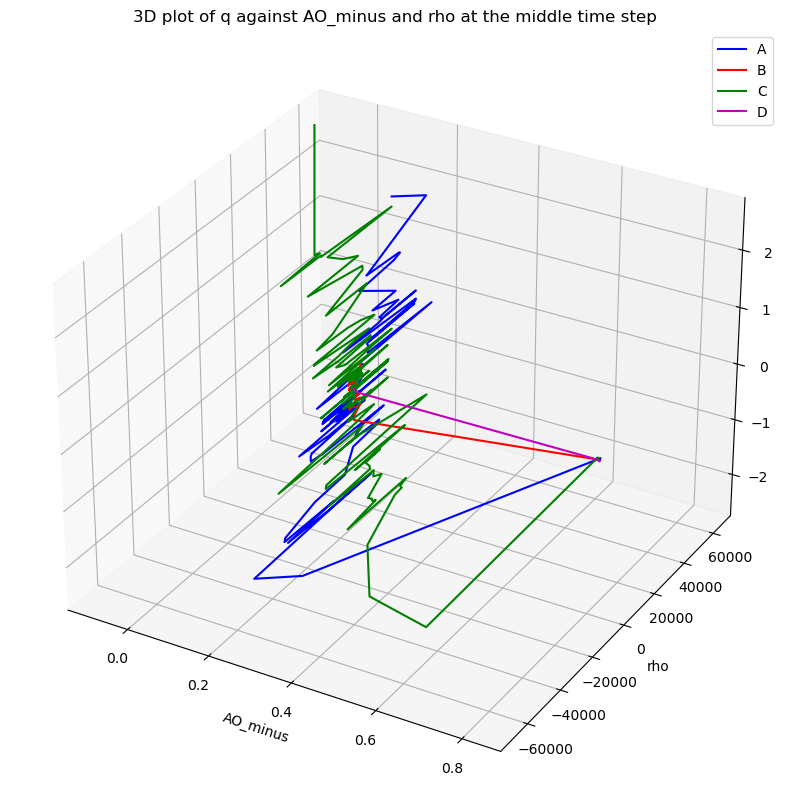

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define time parameters
T = 1.0  # total simulation time
dx = 1  # spatial step size in x direction
dy = 1  # spatial step size in y direction

# Define constants
W = 1  # Width of the road in km
r_i = {'A': 0.89, 'B': 0.78, 'C': 0.74, 'D': 0.50}
D_A, D_B, D_C, D_D = 0.00006, 0.00005, 0.00004, 0.00003  # Diffusion coefficients
AOmax_A, AOmax_B, AOmax_C, AOmax_D = 0.86, 0.78, 0.68, 0.50
a_A, a_B, a_C, a_D = 0.0018 * 0.0006, 0.0026 * 0.0014, 0.004 * 0.0016, 0.0065 * 0.0022

# Initialize densities
rho_A = np.zeros((50, 100))
rho_B = np.zeros((50, 100))
rho_C = np.zeros((50, 100))
rho_D = np.zeros((50, 100))

# Initialize AO matrix
AO = np.zeros((50, 100))

# Assign initial densities and AO based on the condition x < 25 or x >= 25
for x in range(50):
    if x < 25:
        rho_A[x, :] = 100
        rho_B[x, :] = 50
        rho_C[x, :] = 200
        rho_D[x, :] = 25
        AO[x, :] = 0.24
    else:
        rho_A[x, :] = 1200
        rho_B[x, :] = 400
        rho_C[x, :] = 500
        rho_D[x, :] = 100
        AO[x, :] = 0.82

# Initialize velocity fields
u_x_A = np.ones((50, 100)) * 45.0
u_y_A = np.ones((50, 100)) * 2.5
u_x_B = np.ones((50, 100)) * 42.1
u_y_B = np.ones((50, 100)) * 1.4
u_x_C = np.ones((50, 100)) * 52.9
u_y_C = np.ones((50, 100)) * 5.6
u_x_D = np.ones((50, 100)) * 47.2
u_y_D = np.ones((50, 100)) * 4.3

# Define inflow values
q_A_inflow = 500
q_B_inflow = 100
q_C_inflow = 50
q_D_inflow = 10

# Determine maximum velocities
u_x_max = max(np.max(u_x_A), np.max(u_x_B), np.max(u_x_C), np.max(u_x_D))
u_y_max = max(np.max(u_y_A), np.max(u_y_B), np.max(u_y_C), np.max(u_y_D))

# Determine maximum diffusion coefficient
D_max = max(D_A, D_B, D_C, D_D)

# Calculate the time step to satisfy CFL conditions
dt_advection_x = dx / u_x_max
dt_advection_y = dy / u_y_max
dt_diffusion_x = dx**2 / (2 * D_max)
dt_diffusion_y = dy**2 / (2 * D_max)

# Choose the smaller time step to ensure all conditions are satisfied
dt = min(dt_advection_x, dt_advection_y, dt_diffusion_x, dt_diffusion_y)

# Calculate number of time steps
time_steps = int(T / dt) + 1  # +1 ensures that final time is also included
time = np.arange(0, T, dt)  # array of times

# Define the finite difference gradient function
def finite_difference_gradient(f, dx, dy):
    grad_x = np.zeros(f.shape)
    grad_y = np.zeros(f.shape)
    grad_x[1:-1, 1:-1] = (f[2:, 1:-1] - f[:-2, 1:-1]) / (2 * dx)
    grad_y[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, :-2]) / (2 * dy)
    return grad_x, grad_y

# Define the finite difference second derivative function
def finite_difference_laplacian(f, dx, dy):
    laplacian_x = np.zeros(f.shape)
    laplacian_y = np.zeros(f.shape)
    laplacian_x[1:-1, 1:-1] = (f[2:, 1:-1] - 2 * f[1:-1, 1:-1] + f[:-2, 1:-1]) / dx**2
    laplacian_y[1:-1, 1:-1] = (f[1:-1, 2:] - 2 * f[1:-1, 1:-1] + f[1:-1, :-2]) / dy**2
    return laplacian_x, laplacian_y

# Function to update the density field
def update_density(rho, u_x, u_y, D, AO, AO_minus, dt, dx, dy, q_inflow, W, a):
    rho_new = np.copy(rho)

    AO_diff_x, AO_diff_y = finite_difference_gradient(AO - AO_minus, dx, dy)
    laplacian_x, laplacian_y = finite_difference_laplacian(AO - AO_minus, dx, dy)

    # Update densities excluding boundaries
    rho_new[1:-1, 1:-1] = (rho[1:-1, 1:-1]
                           - dt * (W / a) * ((u_x[1:-1, 1:-1] * AO_diff_x[1:-1, 1:-1])
                           + (u_y[1:-1, 1:-1] * AO_diff_y[1:-1, 1:-1]))
                           + dt * D * (W / a) * (laplacian_x[1:-1, 1:-1] + laplacian_y[1:-1, 1:-1]))

    # Apply inflow
    rho_new[:, 0] += q_inflow * dt

    return rho_new

# Function to calculate velocity
def calculate_ui(u_fi, r_i, AO_max_i, AO):
    return u_fi * (1 - np.exp(1 - np.exp(r_i * (AO_max_i / AO - 1))))

# Function to calculate q
def calculate_q(u_x, u_y, AO, AO_minus, D, W, a):
    AO_diff_x, AO_diff_y = finite_difference_gradient(AO - AO_minus, dx, dy)
    q = (W / a) * (u_x * (AO - AO_minus) - D * AO_diff_x + u_y * (AO - AO_minus) - D * AO_diff_y)
    return q

# Initialize lists to store q values over time
q_A_time = []
q_B_time = []
q_C_time = []
q_D_time = []

# Initialize lists to store AO_minus values over time
AO_minus_A_time = []
AO_minus_B_time = []
AO_minus_C_time = []
AO_minus_D_time = []

# Initialize lists to store rho values over time
rho_A_time = []
rho_B_time = []
rho_C_time = []
rho_D_time = []

# Simulate densities and compute eigenvalues and velocities over time
for t in range(time_steps - 1):
    # Update densities
    AO_minus_A = AO - a_A * rho_A / W
    AO_minus_B = AO - a_B * rho_B / W
    AO_minus_C = AO - a_C * rho_C / W
    AO_minus_D = AO - a_D * rho_D / W

    # Store AO_minus values
    AO_minus_A_time.append(AO_minus_A)
    AO_minus_B_time.append(AO_minus_B)
    AO_minus_C_time.append(AO_minus_C)
    AO_minus_D_time.append(AO_minus_D)

    rho_A = update_density(rho_A, u_x_A, u_y_A, D_A, AO, AO_minus_A, dt, dx, dy, q_A_inflow, W, a_A)
    rho_B = update_density(rho_B, u_x_B, u_y_B, D_B, AO, AO_minus_B, dt, dx, dy, q_B_inflow, W, a_B)
    rho_C = update_density(rho_C, u_x_C, u_y_C, D_C, AO, AO_minus_C, dt, dx, dy, q_C_inflow, W, a_C)
    rho_D = update_density(rho_D, u_x_D, u_y_D, D_D, AO, AO_minus_D, dt, dx, dy, q_D_inflow, W, a_D)

    # Store rho values
    rho_A_time.append(rho_A)
    rho_B_time.append(rho_B)
    rho_C_time.append(rho_C)
    rho_D_time.append(rho_D)

    # Calculate velocities
    u_x_A = calculate_ui(45.0, r_i['A'], AOmax_A, AO)
    u_y_A = calculate_ui(2.5, r_i['A'], AOmax_A, AO)
    u_x_B = calculate_ui(42.1, r_i['B'], AOmax_B, AO)
    u_y_B = calculate_ui(1.4, r_i['B'], AOmax_B, AO)
    u_x_C = calculate_ui(52.9, r_i['C'], AOmax_C, AO)
    u_y_C = calculate_ui(5.6, r_i['C'], AOmax_C, AO)
    u_x_D = calculate_ui(47.2, r_i['D'], AOmax_D, AO)
    u_y_D = calculate_ui(4.3, r_i['D'], AOmax_D, AO)

    # Calculate q values
    q_A = calculate_q(u_x_A, u_y_A, AO, AO_minus_A, D_A, W, a_A)
    q_B = calculate_q(u_x_B, u_y_B, AO, AO_minus_B, D_B, W, a_B)
    q_C = calculate_q(u_x_C, u_y_C, AO, AO_minus_C, D_C, W, a_C)
    q_D = calculate_q(u_x_D, u_y_D, AO, AO_minus_D, D_D, W, a_D)

    # Store q values
    q_A_time.append(q_A)
    q_B_time.append(q_B)
    q_C_time.append(q_C)
    q_D_time.append(q_D)

# Convert lists to arrays for plotting
q_A_time = np.array(q_A_time)
q_B_time = np.array(q_B_time)
q_C_time = np.array(q_C_time)
q_D_time = np.array(q_D_time)

AO_minus_A_time = np.array(AO_minus_A_time)
AO_minus_B_time = np.array(AO_minus_B_time)
AO_minus_C_time = np.array(AO_minus_C_time)
AO_minus_D_time = np.array(AO_minus_D_time)

rho_A_time = np.array(rho_A_time)
rho_B_time = np.array(rho_B_time)
rho_C_time = np.array(rho_C_time)
rho_D_time = np.array(rho_D_time)

from mpl_toolkits.mplot3d import Axes3D

# Find the middle time step
middle_index = len(time) // 2

# Extract values at the middle time step
q_A_middle = q_A_time[middle_index]
AO_minus_A_middle = AO_minus_A_time[middle_index]
rho_A_middle = rho_A_time[middle_index]

q_B_middle = q_B_time[middle_index]
AO_minus_B_middle = AO_minus_B_time[middle_index]
rho_B_middle = rho_B_time[middle_index]

q_C_middle = q_C_time[middle_index]
AO_minus_C_middle = AO_minus_C_time[middle_index]
rho_C_middle = rho_C_time[middle_index]

q_D_middle = q_D_time[middle_index]
AO_minus_D_middle = AO_minus_D_time[middle_index]
rho_D_middle = rho_D_time[middle_index]

# Flatten and sort the matrices to get line plot data
def flatten_and_sort(AO_minus_middle, rho_middle, q_middle):
    AO_minus_flat = AO_minus_middle.flatten()
    rho_flat = rho_middle.flatten()
    q_flat = q_middle.flatten()
    sort_indices = np.lexsort((rho_flat, AO_minus_flat))
    return AO_minus_flat[sort_indices], rho_flat[sort_indices], q_flat[sort_indices]

AO_minus_A_sorted, rho_A_sorted, q_A_sorted = flatten_and_sort(AO_minus_A_middle, rho_A_middle, q_A_middle)
AO_minus_B_sorted, rho_B_sorted, q_B_sorted = flatten_and_sort(AO_minus_B_middle, rho_B_middle, q_B_middle)
AO_minus_C_sorted, rho_C_sorted, q_C_sorted = flatten_and_sort(AO_minus_C_middle, rho_C_middle, q_C_middle)
AO_minus_D_sorted, rho_D_sorted, q_D_sorted = flatten_and_sort(AO_minus_D_middle, rho_D_middle, q_D_middle)

# Create the 3D plot with lines
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot q_A, q_B, q_C, and q_D as line functions of AO_minus and rho
ax.plot3D(AO_minus_A_sorted, rho_A_sorted, q_A_sorted, color='b', label='A')
ax.plot3D(AO_minus_B_sorted, rho_B_sorted, q_B_sorted, color='r', label='B')
ax.plot3D(AO_minus_C_sorted, rho_C_sorted, q_C_sorted, color='g', label='C')
ax.plot3D(AO_minus_D_sorted, rho_D_sorted, q_D_sorted, color='m', label='D')

ax.set_xlabel('AO_minus')
ax.set_ylabel('rho')
ax.set_zlabel('q')
ax.set_title('3D plot of q against AO_minus and rho at the middle time step')

plt.legend()
plt.show()


Propagation speed for small disturbance(PSSD) corresponding with an uncongested upstream section and highly congested downstream section

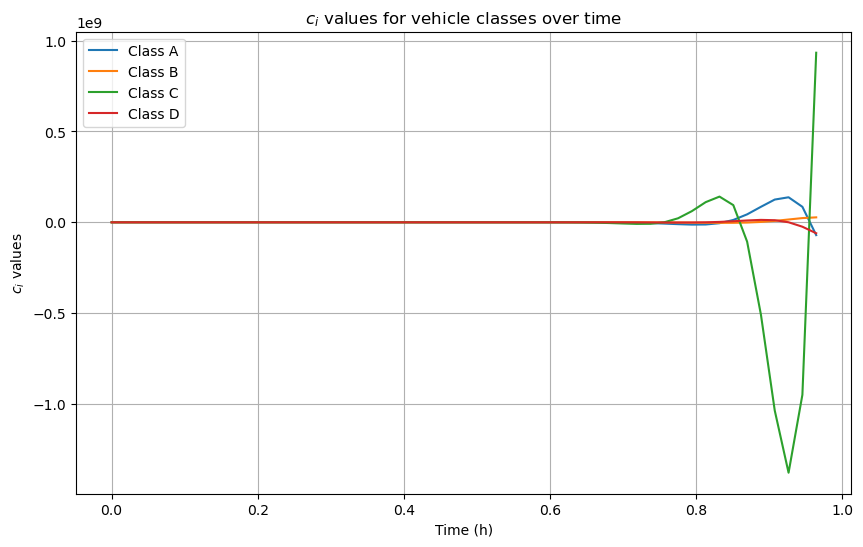

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define time parameters
T = 1.0  # total simulation time in hours
dx = 1  # spatial step size in km
dy = 1  # spatial step size in km

# Define constants
W = 1  # Width of the road in km
r_i = {'A': 0.89, 'B': 0.78, 'C': 0.74, 'D': 0.50}
D_A, D_B, D_C, D_D = 0.00006, 0.00005, 0.00004,0.00003  # Diffusion coefficients in km^2/h
AOmax_A, AOmax_B, AOmax_C, AOmax_D = 0.86, 0.78, 0.68, 0.50
a_A, a_B, a_C, a_D = 0.0018 * 0.0006, 0.0026 * 0.0014, 0.004 * 0.0016, 0.0065 * 0.0022

# Initialize densities
rho_A = np.zeros((50, 100))
rho_B = np.zeros((50, 100))
rho_C = np.zeros((50, 100))
rho_D = np.zeros((50, 100))

# Initialize AO matrix
AO = np.zeros((50, 100))

# Assign initial densities and AO based on the condition x < 25 or x >= 25
for x in range(50):
    if x < 25:
        rho_A[x, :] = 100
        rho_B[x, :] = 50
        rho_C[x, :] = 200
        rho_D[x, :] = 25
        AO[x, :] = 0.24
    else:
        rho_A[x, :] = 1200
        rho_B[x, :] = 400
        rho_C[x, :] = 500
        rho_D[x, :] = 100
        AO[x, :] = 0.82

# Initialize velocity fields (in km/h)
u_x_A = np.ones((50, 100)) * 45.0
u_y_A = np.ones((50, 100)) * 2.5
u_x_B = np.ones((50, 100)) * 42.1
u_y_B = np.ones((50, 100)) * 1.4
u_x_C = np.ones((50, 100)) * 52.9
u_y_C = np.ones((50, 100)) * 5.6
u_x_D = np.ones((50, 100)) * 47.2
u_y_D = np.ones((50, 100)) * 4.3

# Define inflow values (vehicles per hour)
q_A_inflow = 500
q_B_inflow = 100
q_C_inflow = 50
q_D_inflow = 10

# Determine maximum velocities
u_x_max = max(np.max(u_x_A), np.max(u_x_B), np.max(u_x_C), np.max(u_x_D))
u_y_max = max(np.max(u_y_A), np.max(u_y_B), np.max(u_y_C), np.max(u_y_D))

# Determine maximum diffusion coefficient
D_max = max(D_A, D_B, D_C, D_D)

# Calculate the time step to satisfy CFL conditions
dt_advection_x = dx / u_x_max
dt_advection_y = dy / u_y_max
dt_diffusion_x = dx**2 / (2 * D_max)
dt_diffusion_y = dy**2 / (2 * D_max)

# Choose the smaller time step to ensure all conditions are satisfied
dt = min(dt_advection_x, dt_advection_y, dt_diffusion_x, dt_diffusion_y)

# Calculate number of time steps
time_steps = int(T / dt)  # no need for +1 as we handle it in the loop
time = np.arange(0, T, dt)  # array of times

# Define the finite difference gradient function
def finite_difference_gradient(f, dx, dy):
    grad_x = np.zeros(f.shape)
    grad_y = np.zeros(f.shape)
    grad_x[1:-1, 1:-1] = (f[2:, 1:-1] - f[:-2, 1:-1]) / (2 * dx)
    grad_y[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, :-2]) / (2 * dy)
    return grad_x, grad_y

# Define the finite difference second derivative function
def finite_difference_laplacian(f, dx, dy):
    laplacian_x = np.zeros(f.shape)
    laplacian_y = np.zeros(f.shape)
    laplacian_x[1:-1, 1:-1] = (f[2:, 1:-1] - 2 * f[1:-1, 1:-1] + f[:-2, 1:-1]) / dx**2
    laplacian_y[1:-1, 1:-1] = (f[1:-1, 2:] - 2 * f[1:-1, 1:-1] + f[1:-1, :-2]) / dy**2
    return laplacian_x, laplacian_y

# Function to update the density field
def update_density(rho, u_x, u_y, D, AO, AO_minus, dt, dx, dy, q_inflow, W, a):
    rho_new = np.copy(rho)
    
    AO_diff_x, AO_diff_y = finite_difference_gradient(AO - AO_minus, dx, dy)
    laplacian_x, laplacian_y = finite_difference_laplacian(AO - AO_minus, dx, dy)

    # Update densities excluding boundaries
    rho_new[1:-1, 1:-1] = (rho[1:-1, 1:-1]
                           - dt * (W / a) * ((u_x[1:-1, 1:-1] * AO_diff_x[1:-1, 1:-1])
                           + (u_y[1:-1, 1:-1] * AO_diff_y[1:-1, 1:-1]))
                           + dt * D * (W / a) * (laplacian_x[1:-1, 1:-1] + laplacian_y[1:-1, 1:-1]))

    # Apply inflow
    rho_new[:, 0] += q_inflow * dt
    
    return rho_new

# Function to calculate velocity
def calculate_ui(u_fi, r_i, AO_max_i, AO):
    return u_fi * (1 - np.exp(1 - np.exp(r_i * (AO_max_i / AO - 1))))

# Simulate densities and compute eigenvalues and velocities over time
ci_A = []
ci_B = []
ci_C = []
ci_D = []

for t in range(time_steps):
    # Update densities
    AO_minus_A = AO - a_A * rho_A / W
    AO_minus_B = AO - a_B * rho_B / W
    AO_minus_C = AO - a_C * rho_C / W
    AO_minus_D = AO - a_D * rho_D / W
    
    rho_A = update_density(rho_A, u_x_A, u_y_A, D_A, AO, AO_minus_A, dt, dx, dy, q_A_inflow, W, a_A)
    rho_B = update_density(rho_B, u_x_B, u_y_B, D_B, AO, AO_minus_B, dt, dx, dy, q_B_inflow, W, a_B)
    rho_C = update_density(rho_C, u_x_C, u_y_C, D_C, AO, AO_minus_C, dt, dx, dy, q_C_inflow, W, a_C)
    rho_D = update_density(rho_D, u_x_D, u_y_D, D_D, AO, AO_minus_D, dt, dx, dy, q_D_inflow, W, a_D)

    # Calculate partial derivatives
    dqA_dkA = finite_difference_gradient(rho_A, dx, dy)
    dqB_dkB = finite_difference_gradient(rho_B, dx, dy)
    dqC_dkC = finite_difference_gradient(rho_C, dx, dy)
    dqD_dkD = finite_difference_gradient(rho_D, dx, dy)
    
    # Calculate second partial derivatives
    d2qA_dAO2 = (finite_difference_laplacian(dqA_dkA[0], dx, dy) + finite_difference_laplacian(dqA_dkA[1], dx, dy))
    d2qB_dAO2 = (finite_difference_laplacian(dqB_dkB[0], dx, dy) + finite_difference_laplacian(dqB_dkB[1], dx, dy))
    d2qC_dAO2 = (finite_difference_laplacian(dqC_dkC[0], dx, dy) + finite_difference_laplacian(dqC_dkC[1], dx, dy))
    d2qD_dAO2 = (finite_difference_laplacian(dqD_dkD[0], dx, dy) + finite_difference_laplacian(dqD_dkD[1], dx, dy))
    
    # Integrate over the spatial domain to get c values
    ci_A.append(np.sum(dqA_dkA[0] + dqA_dkA[1] + d2qA_dAO2))
    ci_B.append(np.sum(dqB_dkB[0] + dqB_dkB[1] + d2qB_dAO2))
    ci_C.append(np.sum(dqC_dkC[0] + dqC_dkC[1] + d2qC_dAO2))
    ci_D.append(np.sum(dqD_dkD[0] + dqD_dkD[1] + d2qD_dAO2))
# Adjust the time array to match the length of the ci lists
time = np.arange(0, T, dt)[:len(ci_A)] # Trim the time array

# Plot the c values over time
plt.figure(figsize=(10, 6))
plt.plot(time, ci_A, label='Class A')
plt.plot(time, ci_B, label='Class B')
plt.plot(time, ci_C, label='Class C')
plt.plot(time, ci_D, label='Class D')
plt.xlabel('Time (h)')
plt.ylabel('$c_i$ values')
plt.title('$c_i$ values for vehicle classes over time')
plt.legend()
plt.grid(True)
plt.show()


Propagation speed for small disturbance (PSSD) corresponding to a road stream with highly congested upstream section and uncongested downstream section

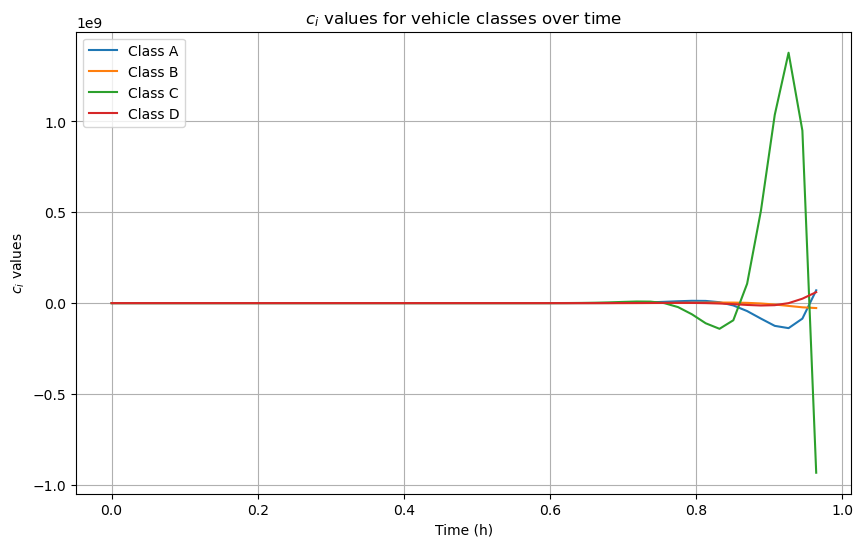

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define time parameters
T = 1.0  # total simulation time in hours
dx = 1  # spatial step size in km
dy = 1  # spatial step size in km

# Define constants
W = 1  # Width of the road in km
r_i = {'A': 0.89, 'B': 0.78, 'C': 0.74, 'D': 0.50}
D_A, D_B, D_C, D_D = 0.00006, 0.00005, 0.00004,0.00003  # Diffusion coefficients in km^2/h
AOmax_A, AOmax_B, AOmax_C, AOmax_D = 0.86, 0.78, 0.68, 0.50
a_A, a_B, a_C, a_D = 0.0018 * 0.0006, 0.0026 * 0.0014, 0.004 * 0.0016, 0.0065 * 0.0022

# Initialize densities
rho_A = np.zeros((50, 100))
rho_B = np.zeros((50, 100))
rho_C = np.zeros((50, 100))
rho_D = np.zeros((50, 100))

# Initialize AO matrix
AO = np.zeros((50, 100))

# Assign initial densities and AO based on the condition x < 25 or x >= 25
for x in range(50):
    if x < 25:
        rho_A[x, :] = 1200
        rho_B[x, :] = 400
        rho_C[x, :] = 500
        rho_D[x, :] = 100
        AO[x, :] = 0.82
    else:
        rho_A[x, :] = 100
        rho_B[x, :] = 50
        rho_C[x, :] = 200
        rho_D[x, :] = 25
        AO[x, :] = 0.24

# Initialize velocity fields (in km/h)
u_x_A = np.ones((50, 100)) * 45.0
u_y_A = np.ones((50, 100)) * 2.5
u_x_B = np.ones((50, 100)) * 42.1
u_y_B = np.ones((50, 100)) * 1.4
u_x_C = np.ones((50, 100)) * 52.9
u_y_C = np.ones((50, 100)) * 5.6
u_x_D = np.ones((50, 100)) * 47.2
u_y_D = np.ones((50, 100)) * 4.3

# Define inflow values (vehicles per hour)
q_A_inflow = 500
q_B_inflow = 100
q_C_inflow = 50
q_D_inflow = 10

# Determine maximum velocities
u_x_max = max(np.max(u_x_A), np.max(u_x_B), np.max(u_x_C), np.max(u_x_D))
u_y_max = max(np.max(u_y_A), np.max(u_y_B), np.max(u_y_C), np.max(u_y_D))

# Determine maximum diffusion coefficient
D_max = max(D_A, D_B, D_C, D_D)

# Calculate the time step to satisfy CFL conditions
dt_advection_x = dx / u_x_max
dt_advection_y = dy / u_y_max
dt_diffusion_x = dx**2 / (2 * D_max)
dt_diffusion_y = dy**2 / (2 * D_max)

# Choose the smaller time step to ensure all conditions are satisfied
dt = min(dt_advection_x, dt_advection_y, dt_diffusion_x, dt_diffusion_y)

# Calculate number of time steps
time_steps = int(T / dt)  # no need for +1 as we handle it in the loop
time = np.arange(0, T, dt)  # array of times

# Define the finite difference gradient function
def finite_difference_gradient(f, dx, dy):
    grad_x = np.zeros(f.shape)
    grad_y = np.zeros(f.shape)
    grad_x[1:-1, 1:-1] = (f[2:, 1:-1] - f[:-2, 1:-1]) / (2 * dx)
    grad_y[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, :-2]) / (2 * dy)
    return grad_x, grad_y

# Define the finite difference second derivative function
def finite_difference_laplacian(f, dx, dy):
    laplacian_x = np.zeros(f.shape)
    laplacian_y = np.zeros(f.shape)
    laplacian_x[1:-1, 1:-1] = (f[2:, 1:-1] - 2 * f[1:-1, 1:-1] + f[:-2, 1:-1]) / dx**2
    laplacian_y[1:-1, 1:-1] = (f[1:-1, 2:] - 2 * f[1:-1, 1:-1] + f[1:-1, :-2]) / dy**2
    return laplacian_x, laplacian_y

# Function to update the density field
def update_density(rho, u_x, u_y, D, AO, AO_minus, dt, dx, dy, q_inflow, W, a):
    rho_new = np.copy(rho)
    
    AO_diff_x, AO_diff_y = finite_difference_gradient(AO - AO_minus, dx, dy)
    laplacian_x, laplacian_y = finite_difference_laplacian(AO - AO_minus, dx, dy)

    # Update densities excluding boundaries
    rho_new[1:-1, 1:-1] = (rho[1:-1, 1:-1]
                           - dt * (W / a) * ((u_x[1:-1, 1:-1] * AO_diff_x[1:-1, 1:-1])
                           + (u_y[1:-1, 1:-1] * AO_diff_y[1:-1, 1:-1]))
                           + dt * D * (W / a) * (laplacian_x[1:-1, 1:-1] + laplacian_y[1:-1, 1:-1]))

    # Apply inflow
    rho_new[:, 0] += q_inflow * dt
    
    return rho_new

# Function to calculate velocity
def calculate_ui(u_fi, r_i, AO_max_i, AO):
    return u_fi * (1 - np.exp(1 - np.exp(r_i * (AO_max_i / AO - 1))))

# Simulate densities and compute eigenvalues and velocities over time
ci_A = []
ci_B = []
ci_C = []
ci_D = []

for t in range(time_steps):
    # Update densities
    AO_minus_A = AO - a_A * rho_A / W
    AO_minus_B = AO - a_B * rho_B / W
    AO_minus_C = AO - a_C * rho_C / W
    AO_minus_D = AO - a_D * rho_D / W
    
    rho_A = update_density(rho_A, u_x_A, u_y_A, D_A, AO, AO_minus_A, dt, dx, dy, q_A_inflow, W, a_A)
    rho_B = update_density(rho_B, u_x_B, u_y_B, D_B, AO, AO_minus_B, dt, dx, dy, q_B_inflow, W, a_B)
    rho_C = update_density(rho_C, u_x_C, u_y_C, D_C, AO, AO_minus_C, dt, dx, dy, q_C_inflow, W, a_C)
    rho_D = update_density(rho_D, u_x_D, u_y_D, D_D, AO, AO_minus_D, dt, dx, dy, q_D_inflow, W, a_D)

    # Calculate partial derivatives
    dqA_dkA = finite_difference_gradient(rho_A, dx, dy)
    dqB_dkB = finite_difference_gradient(rho_B, dx, dy)
    dqC_dkC = finite_difference_gradient(rho_C, dx, dy)
    dqD_dkD = finite_difference_gradient(rho_D, dx, dy)
    
    # Calculate second partial derivatives
    d2qA_dAO2 = (finite_difference_laplacian(dqA_dkA[0], dx, dy) + finite_difference_laplacian(dqA_dkA[1], dx, dy))
    d2qB_dAO2 = (finite_difference_laplacian(dqB_dkB[0], dx, dy) + finite_difference_laplacian(dqB_dkB[1], dx, dy))
    d2qC_dAO2 = (finite_difference_laplacian(dqC_dkC[0], dx, dy) + finite_difference_laplacian(dqC_dkC[1], dx, dy))
    d2qD_dAO2 = (finite_difference_laplacian(dqD_dkD[0], dx, dy) + finite_difference_laplacian(dqD_dkD[1], dx, dy))
    
    # Integrate over the spatial domain to get c values
    ci_A.append(np.sum(dqA_dkA[0] + dqA_dkA[1] + d2qA_dAO2))
    ci_B.append(np.sum(dqB_dkB[0] + dqB_dkB[1] + d2qB_dAO2))
    ci_C.append(np.sum(dqC_dkC[0] + dqC_dkC[1] + d2qC_dAO2))
    ci_D.append(np.sum(dqD_dkD[0] + dqD_dkD[1] + d2qD_dAO2))
# Adjust the time array to match the length of the ci lists
time = np.arange(0, T, dt)[:len(ci_A)] # Trim the time array

# Plot the c values over time
plt.figure(figsize=(10, 6))
plt.plot(time, ci_A, label='Class A')
plt.plot(time, ci_B, label='Class B')
plt.plot(time, ci_C, label='Class C')
plt.plot(time, ci_D, label='Class D')
plt.xlabel('Time (h)')
plt.ylabel('$c_i$ values')
plt.title('$c_i$ values for vehicle classes over time')
plt.legend()
plt.grid(True)
plt.show()
